In [2]:
import qpsolvers
from os.path import exists
import pickle

import sn_bayes
from sn_bayes import longevity_bayes
from sn_bayes.utils import complexity_check
from sn_bayes.utils import get_var_positions
from sn_bayes.utils import get_var_val_positions
from sn_bayes.utils import make_tree
from sn_bayes.utils import bayesInitialize
from sn_bayes.utils import query
from sn_bayes.utils import internal_query
from sn_bayes.utils import internal_query
from sn_bayes.utils import explain_why_bad
from sn_bayes.utils import explain_why_good
from sn_bayes.utils import create_query

import sn_service.service_spec.bayesian_pb2
from sn_service.service_spec.bayesian_pb2 import Query
import sn_service.service_spec.bayesian_pb2_grpc as grpc_bayes_grpc
import sn_service.service_spec.bayesian_pb2
from sn_service.service_spec.bayesian_pb2 import BayesianNetworkQuery
from sn_service.service_spec.bayesian_pb2 import QueryId
from sn_service.service_spec.bayesian_pb2 import Id

from sn_bayes.utils import any_of
from sn_bayes.utils import all_of
from sn_bayes.utils import avg
from sn_bayes.utils import if_then_else
from sn_bayes.utils import bayesInitialize
from sn_bayes.utils import addCpt
from sn_bayes.utils import dependency
from sn_bayes.utils import non_cpt_descriptions

import sn_service.service_spec.bayesian_pb2
from sn_service.service_spec.bayesian_pb2 import BayesianNetwork

import grpc
import pandas as pd
import networkx as nx
import time
import re

import matplotlib.pyplot as plt

In [4]:
if exists("bayesianNetwork.pkl"):
        infile = open("bayesianNetwork.pkl",'rb')
        bayesianNetwork = pickle.load(infile)
        infile.close()
else:
        %time bayesianNetwork,outstr = longevity_bayes.longevity_bayes()
        print (outstr)
        outfile = open("bayesianNetwork.pkl",'wb')
        pickle.dump(bayesianNetwork,outfile)
        outfile.close()
        
path = './sn_bayes'
text_file = open(f'{path}/longevity_bayes.py')
#text_file = open('./sn_bayes/longevity_bayes_short.py')
file_content = text_file.read()
#print(file_content)
text_file.close()

In [5]:
#
complexity_check(bayesianNetwork)
#
var_positions = get_var_positions(bayesianNetwork)
#
var_val_positions = get_var_val_positions(bayesianNetwork)

In [10]:
# We create a spreadsheet of the above for reference
rows_list = []
outname = "varvals.csv"
for var, valdict in var_val_positions.items():
    rowdict = {} 
    rows_list.append(rowdict)
    varstr= var +"("
    for val, pos in valdict.items():
        varstr += val
        varstr+= ","
            
    varstr=varstr[:-1]+")"
    rowdict["variable"] = varstr        
#
df = pd.DataFrame(rows_list)      
# df.to_csv(outname, index = False)

In [15]:
G = nx.DiGraph()
regex = re.compile(r'^([a-z_]*)\(.*')
for index, row in df.iterrows():
    for col in df.columns:
        if row[col] is not None:
            node = row[col][:-1] if col == "level0" else row[col]
            G.add_node(node)           
for node1 in G.nodes:
    for node2 in G.nodes:
        match = regex.match(node1)
        if (node1+',' in node2) or (match is not None and match.group(1)+"," in node2): 
            G.add_edge(node1,node2)
            if match is not None and match.group(1)+"," in node2:
                print (node1)
                print(node2)    

heart_rate_anomaly(heart_rate_anomaly,no_heart_rate_anomaly)
heart_rate_anomaly(heart_rate_anomaly,no_heart_rate_anomaly)
steps_anomaly(steps_anomaly,no_steps_anomaly)
steps_anomaly(steps_anomaly,no_steps_anomaly)
workout_anomaly(workout_anomaly,no_workout_anomaly)
workout_anomaly(workout_anomaly,no_workout_anomaly)
walking_speed_anomaly(walking_speed_anomaly,no_walking_speed_anomaly)
walking_speed_anomaly(walking_speed_anomaly,no_walking_speed_anomaly)
walking_speed_variability_anomaly(walking_speed_variability_anomaly,no_walking_speed_variability_anomaly)
walking_speed_variability_anomaly(walking_speed_variability_anomaly,no_walking_speed_variability_anomaly)
stride_variability_anomaly(stride_variability_anomaly,no_stride_variability_anomaly)
stride_variability_anomaly(stride_variability_anomaly,no_stride_variability_anomaly)
step_asymmetry_anomaly(step_asymmetry_anomaly,no_step_asymmetry_anomaly)
step_asymmetry_anomaly(step_asymmetry_anomaly,no_step_asymmetry_anomaly)
step_variabili

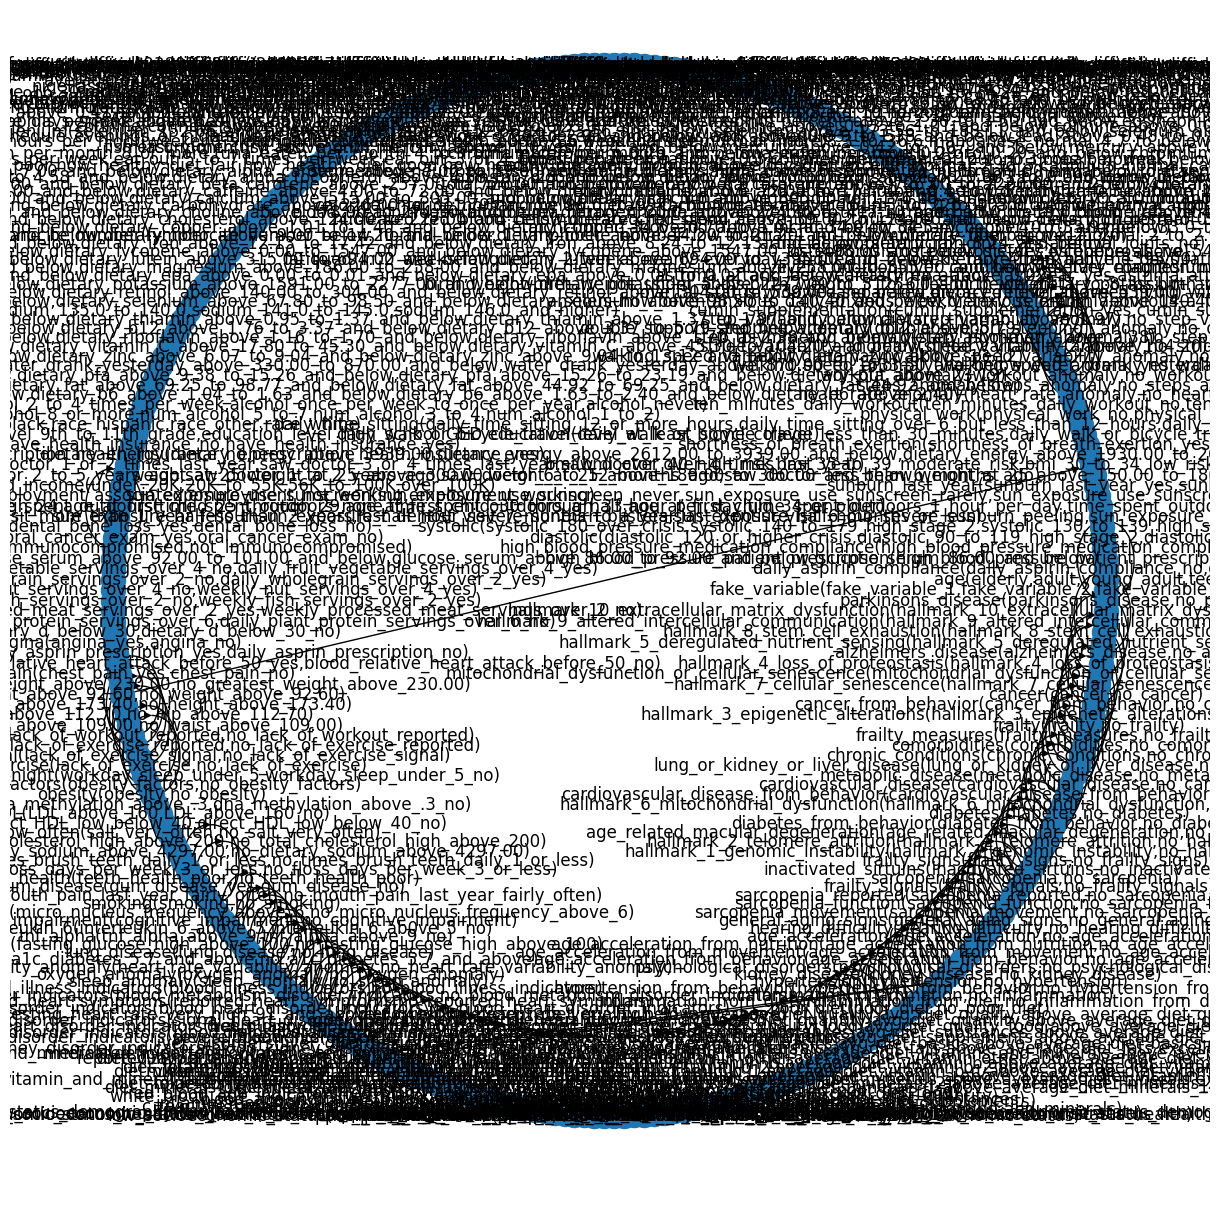

In [17]:
plt.figure(3,figsize=(12,12)) 
#nx.draw(G, with_labels=True)  
#nx.draw_random(G, with_labels=True)   
nx.draw_circular(G, with_labels=True)  
#nx.draw_spectral(G, with_labels=True)   
#nx.draw_spring(G, with_labels=True)  

In [18]:
# Pomegranate net we just made with the description. Compile the net so we can compute probabilities with it.
longevity = bayesInitialize(bayesianNetwork)
#
longevity.bake()
# Calls a Pomegranate routine that shows the computed probabilities of every variable. 
longevity.predict_proba({}) 

array([{
           "class" : "Distribution",
           "dtype" : "str",
           "name" : "DiscreteDistribution",
           "parameters" : [
               {
                   "fake_variable_1" : 0.049999997173818166,
                   "fake_variable_2" : 0.250000052888803,
                   "fake_variable_3" : 0.2999997861930072,
                   "fake_variable_4" : 0.20000016274835297,
                   "fake_variable_5" : 0.20000000099601856
               }
           ],
           "frozen" : false
       }                                                    ,
       {
           "class" : "Distribution",
           "dtype" : "str",
           "name" : "DiscreteDistribution",
           "parameters" : [
               {
                   "elderly" : 0.04996686518206732,
                   "adult" : 0.24996741459510577,
                   "young_adult" : 0.3000669946930739,
                   "teen" : 0.1999993644402697,
                   "child" : 0.19999936108948332
  